In [1]:
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# utils

In [2]:
def Hbeta_vec(distances, betas):
    """
    Function that computes the Gaussian kernel values given a vector of
    squared Euclidean distances, and the precision of the Gaussian kernel.
    The function also computes the perplexity of the distribution.
    From Parametric t-SNE for matlab at https://lvdmaaten.github.io/tsne/
    Parameters
    ----------
    distances: 2-d array_like, (N,N)
        Square matrix of distances between data points
    betas: 1-d array_like, (N,)
        Vector of precisions of the Gaussian kernel. beta = (2 sigma**2)^-1
    Returns
    -------
    H: 1-d array_like, (N,)
        Entropy of each point
    p_matr: 2-d array_like, (N,N)
        array of probability values
        The scalar formula for p_matr is:
        p_matr = np.exp(-D * beta) / sum(np.exp(-D * beta))
        This funcion is vectorized and calculates the full P matrix
    """    
    beta_matr = betas.unsqueeze(1) * torch.ones_like(distances)
    p_matr = torch.exp(-distances * beta_matr)
    sumP = torch.sum(p_matr, axis=1)
    H = torch.log(sumP) + (betas * torch.sum(distances * p_matr, axis=1)) / sumP
    p_matr = p_matr / (sumP.unsqueeze(1) * torch.ones_like(p_matr))
    
    return H, p_matr

In [3]:
def Hbeta_scalar(distances, beta):
    """
    Function that computes the Gaussian kernel values given a vector of
    squared Euclidean distances, and the precision of the Gaussian kernel.
    The function also computes the perplexity of the distribution.
    From Parametric t-SNE for matlab at https://lvdmaaten.github.io/tsne/
    Parameters
    ----------
    distances: 1-d array_like, (N,)
        Distance between the current data point and all others
    beta: float
        Precision of the Gaussian kernel. beta = (2 sigma**2)^-1
    Returns
    -------
    H: float
        Entropy
    p_matr: 1-d array_like, (N,)
        array of probability values
        p_matr = np.exp(-D * beta) / sum(np.exp(-D * beta))
    """
    p_matr = torch.exp(-distances * beta)
    sumP = torch.sum(p_matr)
    H = torch.log(sumP) + (beta * torch.sum(distances * p_matr)) / sumP
    p_matr = p_matr / sumP
  
    return H, p_matr

In [4]:
def get_squared_cross_diff(X_):
    """Compute squared differences of sample data vectors.
        Z_ij = ||x_i - x_j||^2, where x_i = X_[i, :]
    Parameters
    ----------
    X_ : 2-d array_like, (N, D)
        Calculates outer vector product
        This is the current batch of input data; `batch_size` x `dimension`
    Returns
    -------
    Z_ij: 2-d array_like, (N, N)
        `batch_size` x `batch_size`
        Matrix of squared differences between x_i and x_j
    """
    batch_size = X_.shape[0] 
    expanded = X_.unsqueeze(1)
    tiled = torch.repeat_interleave(expanded, batch_size, dim=1)
    diffs = tiled - tiled.transpose(0, 1)
    sum_act = torch.sum(torch.pow(diffs,2), axis=2)
    
    return sum_act

In [7]:
# def get_Lmax(num_points):
#     return torch.floor(torch.log2(num_points/4.0))

In [8]:
# def get_multiscale_perplexities(num_points):
#     """From
#     Multiscale stochastic neighbor embedding: Towards parameter-free dimensionality reduction"""
#     Lmax = get_Lmax(num_points)
#     _L_vals = torch.arange(2, Lmax)
#     perplexities = 2.0**(_L_vals)
#     return perplexities

In [5]:
def calc_betas_loop(indata, perplexity, tol=1e-4, max_tries=50):
    """
    Calculate beta values for a desired perplexity via binary search
    Uses a loop; could be made faster with cython
    In my tests, vectorized version (calc_betas_vec) doesn't end up much faster
    likely due to higher memory usage
    Parameters
    ----------
    indata: 2-d array_like, (N,D)
    perplexity: float
        Desired perplexity. See literature on tSNE for details.
        Roughly speaking, this is the number of points which should be considered
        when calculating distances
    tol: float, optional
        Absolute tolerance in the entropy for calculating the beta values
        Once entropy stops shifting by this amount the search stops
    max_tries: int, optional
        Maximum number of iterations to use. Default 50.
    Returns
    -------
    betas: 1-D array_like, (N,)
        Calculated beta values
    Hs: 1-d array_like, (N,)
        Entropy at each point given the
    p_matr: 2-d array_like, (N,N)
        Probability matrix between each pair of points
    """
    logPx = np.log2(perplexity)
       
    num_samps = indata.shape[0]
    betas = torch.ones(num_samps)
    p_matr = torch.zeros([num_samps, num_samps])
    Hs = torch.ones(num_samps)
  
    in_sq_diffs = get_squared_cross_diff(indata)
    loop_samps = range(num_samps)
    for ss in loop_samps:
        betamin = -np.inf
        betamax = np.inf
      
        Di = in_sq_diffs[ss, :]
        H, thisPx = Hbeta_scalar(Di, betas[ss])
        del H
        Hdiff = 100*tol
     
        tries = 0
        while abs(Hdiff) > tol and tries < max_tries:
            # Compute the Gaussian kernel and entropy for the current precision
            H, thisPx = Hbeta_scalar(Di, betas[ss])
            Hdiff = H - logPx
            tries = tries + 1
          
            if Hdiff > 0.0:
                betamin = betas[ss].item()
                if np.isinf(betamax):
                    betas[ss] = betas[ss].item() * 2.0
                else:
                    betas[ss] = (betas[ss].item() + betamax) / 2.0
            else:
                betamax = betas[ss].item()
                if np.isinf(betamin):
                    betas[ss] = betas[ss].item() / 2.0
                else:
                    betas[ss] = (betas[ss].item() + betamin) / 2.0
       
        # Set the final row of P
        p_matr[ss, :] = thisPx
        Hs[ss] = H

    return betas, Hs, p_matr

In [6]:
def _calc_betas_vec(indata, perplexity, tol=1e-4, max_tries=50):
    """
    Calculate beta values for a desired perplexity via binary search
    Vectorized version
    Not documented because not used
    """
    logPx = np.log2(perplexity) # CHECK
    num_samps = indata.shape[0]
    
    in_sq_diffs = get_squared_cross_diff(indata)

    betamins = -np.inf*torch.ones(num_samps)
    betamaxs = np.inf*torch.ones(num_samps)
    betas = torch.ones(num_samps)
    
    # Initialize Hdiffs as some large amount
    overall_Hdiff = 100*tol*torch.ones_like(betas)
    tries = 0
    
    while tries < max_tries:

        # At any given iteration we are only operating on a subset of indices
        use_locs = torch.where(torch.abs(overall_Hdiff) > tol)[0]

        if len(use_locs) == 0:
            break
        
        # Compute the Gaussian kernel and entropy for the current precision
        Di_matr = in_sq_diffs[use_locs,:]
        curH, curP_matr = Hbeta_vec(Di_matr, betas[use_locs])
        Hdiff = curH - logPx
        overall_Hdiff[use_locs] = Hdiff

        # Some locations should have higher beta, some lower beta
        increase_beta_locs = use_locs[Hdiff > 0.0]
        decrease_beta_locs = use_locs[Hdiff <= 0.0]
        
        overlap = np.intersect1d(increase_beta_locs, decrease_beta_locs)
        assert len(overlap) == 0
        
        if len(increase_beta_locs) > 0:
            betamins[increase_beta_locs] = betas[increase_beta_locs]
            betas[increase_beta_locs] = torch.where(np.isinf(betamaxs[increase_beta_locs]), betas[increase_beta_locs]*2.0, (betas[increase_beta_locs] + betamaxs[increase_beta_locs])/2.0)
        
        if len(decrease_beta_locs) > 0:
            betamaxs[decrease_beta_locs] = betas[decrease_beta_locs]
            betas[decrease_beta_locs] = torch.where(np.isinf(betamins[decrease_beta_locs]), betas[decrease_beta_locs]/2.0, (betas[decrease_beta_locs] + betamins[decrease_beta_locs])/2.0)
            
        tries += 1
    
    finalH, p_matr = Hbeta_vec(in_sq_diffs, betas)
    
    return betas, finalH, p_matr

# core

In [7]:
DEFAULT_EPS = 1e-7

In [8]:
# def _make_P_ji(indata, betas, in_sq_diffs=None):
#     """Calculate similarity probabilities based on input data
#     Parameters
#     ----------
#     input : 2d array_like, (N, D)
#         Input data which we wish to calculate similarity probabilities
#     betas : 1d array_like, (N, P)
#         Gaussian kernel used for each point.
#     Returns
#     -------
#     P_ji : 2d array_like, (N,N,P)
#         Similarity probability matrix
#     """
#     if not in_sq_diffs:
#         in_sq_diffs = get_squared_cross_diff(indata)
#     tmp = in_sq_diffs.unsqueeze(2) * betas.unsqueeze(0)
#     P_ji = torch.exp(-1.0*tmp)
#     return P_ji

In [9]:
def _make_P(indata, betas):
    """Torch implementation of _make_P_np.
    Not documented because not used, for example only."""
    in_sq_diffs = get_squared_cross_diff(indata)
    tmp = in_sq_diffs * betas
    P_ = torch.exp(-1.0*tmp)
    P_ = _get_normed_sym(P_)
    return P_

In [10]:
def _get_normed_sym(X_):
    """
    Compute the normalized and symmetrized probability matrix from
    relative probabilities X_, where X_ is a Torch Tensor
    Parameters
    ----------
    X_ : 2-d Tensor (N, N)
        asymmetric probabilities. For instance, X_(i, j) = P(i|j)
    Returns
    -------
    P : 2-d Tensor (N, N)
        symmetric probabilities, making the assumption that P(i|j) = P(j|i)
        Diagonals are all 0s."""
    X_.fill_diagonal_(0.)
    norm_facs = X_.sum(axis=0, keepdim=True)
    X_ = X_ / norm_facs
    X_ = 0.5*(X_ + X_.t())
    
    return X_

In [11]:
def _make_Q(output, alpha):
    """
    Calculate the "Q" probability distribution of the output
    Based on the t-distribution.
    Parameters
    ----------
    output : 2-d Tensor (N, output_dims)
        Output of the neural network
    alpha : float
        `alpha` parameter. Recommend `output_dims` - 1.0
    batch_size : int
        The batch size. output.shape[0] == batch_size but we need it
        provided explicitly
    Returns
    -------
    Q_ : 2-d Tensor (N, N)
        Symmetric "Q" probability distribution; similarity of
        points based on output data
    """
    out_sq_diffs = get_squared_cross_diff(output)
    Q_ = torch.pow((1 + out_sq_diffs/alpha), -(alpha+1)/2)
    Q_ = _get_normed_sym(Q_)
    return Q_

In [12]:
def kl_loss(y_true, y_pred, alpha=1.0, batch_size=None, num_perplexities=None, _eps=DEFAULT_EPS):
    """ Kullback-Leibler Loss function (Torch)
    between the "true" output and the "predicted" output
    Parameters
    ----------
    y_true : 2d array_like (N, N*P)
        Should be the P matrix calculated from input data.
        Differences in input points using a Gaussian probability distribution
        Different P (perplexity) values stacked along dimension 1
    y_pred : 2d array_like (N, output_dims)
        Output of the neural network. We will calculate
        the Q matrix based on this output
    alpha : float, optional
        Parameter used to calculate Q. Default 1.0
    batch_size : int, required
        Number of samples per batch. y_true.shape[0]
    num_perplexities : int, required
        Number of perplexities stacked along axis 1
    Returns
    -------
    kl_loss : tf.Tensor, scalar value
        Kullback-Leibler divergence P_ || Q_
    """
    P_ = y_true
    Q_ = _make_Q(y_pred, alpha)
    
    _tf_eps = torch.tensor(_eps, dtype=P_.dtype)
    
    kls_per_beta = []
    components = torch.chunk(P_, num_perplexities, dim=1)

    for cur_beta_P in components:
        #yrange = tf.range(zz*batch_size, (zz+1)*batch_size)
        #cur_beta_P = tf.slice(P_, [zz*batch_size, [-1, batch_size])
        #cur_beta_P = P_
        kl_matr = torch.mul(cur_beta_P, torch.log(cur_beta_P + _tf_eps) - torch.log(Q_ + _tf_eps))
        kl_matr.fill_diagonal_(0.)
        kl_total_cost_cur_beta = torch.sum(kl_matr)
        kls_per_beta.append(kl_total_cost_cur_beta)
    kl_total_cost = torch.sum(torch.stack(kls_per_beta))
    #kl_total_cost = kl_total_cost_cur_beta
    
    return kl_total_cost

In [13]:
class Parametric_tSNE(nn.Module):
    
    def __init__(self, input_dim, output_dim, perplexities,
                 alpha=1.0, hidden_layer_dims=None,
                 do_pretrain=True, seed=0, use_cuda=False):
        """
        num_inputs : int
            Dimension of the (high-dimensional) input
        num_outputs : int
            Dimension of the (low-dimensional) output
        perplexities:
            Desired perplexit(y/ies). Generally interpreted as the number of neighbors to use
            for distance comparisons but actually doesn't need to be an integer.
            Can be an array for multi-scale.
        Roughly speaking, this is the number of points which should be considered
        when calculating distances between points. Can be None if one provides own training betas.
        alpha: float
            alpha scaling parameter of output t-distribution
        optimizer: string or Optimizer, optional
            default 'adam'. Passed to keras.fit
        batch_size: int, optional
            default 64.
        all_layers: list of keras.layer objects or None
            optional. Layers to use in model. If none provided, uses
            the same structure as van der Maaten 2009
        do_pretrain: bool, optional
            Whether to perform layerwise pretraining. Default True
        seed: int, optional
            Default 0. Seed for Tensorflow state.
        """
        super().__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        if perplexities is not None and not isinstance(perplexities, (list, tuple, np.ndarray, torch.Tensor)):
            perplexities = torch.tensor([perplexities])
        self.perplexities = perplexities
        self.num_perplexities = None
        if perplexities is not None:
            self.num_perplexities = len(perplexities)
        self.alpha = alpha
        self.do_pretrain = do_pretrain
        
        self.use_cuda = use_cuda        
        
        torch.manual_seed(seed)
        np.random.seed(seed)
        
        # If no layers provided, use the same architecture as van der maaten 2009 paper
        if hidden_layer_dims is None:
            hidden_layer_dims = [500, 500, 2000]
        
        self.layers = nn.ModuleList()
        
        cur_dim = input_dim
        for hdim in hidden_layer_dims:
            self.layers.append(nn.Linear(cur_dim, hdim))
            cur_dim = hdim
        self.layers.append(nn.Linear(cur_dim, output_dim))
        
        if self.use_cuda:
            self.cuda()
        
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.sigmoid(layer(x))
        out = self.layers[-1](x)
        return out
    
    def _calc_training_betas(self, training_data, perplexities, beta_batch_size=1000, verbose=False):
        """
        Calculate beta values (gaussian kernel widths) used for training the model
        For memory reasons, only uses beta_batch_size points at a time.
        Parameters
        ----------
        training_data : 2d array_like, (N, D)
        perplexities : float or ndarray-like, (P,)
        beta_batch_size : int, optional
            Only use `beta_batch_size` points to calculate beta values. This is
            for speed and memory reasons. Data must be well-shuffled for this to be effective,
            betas will be calculated based on regular batches of this size
            # TODO K-NN or something would probably be better rather than just
            # batches
        Returns
        -------
        betas : 2D array_like (N,P)
        """
        assert perplexities is not None, "Must provide desired perplexit(y/ies) if training beta values"
        num_pts = len(training_data)
        if not isinstance(perplexities, (list, tuple, np.ndarray, torch.Tensor)):
            perplexities = torch.tensor([perplexities])
        num_perplexities = len(perplexities)
        training_betas = torch.zeros((num_pts, num_perplexities))

        # To calculate betas, only use `beta_batch_size` points at a time
        cur_start = 0
        cur_end = min(cur_start+beta_batch_size, num_pts)
        if verbose:
            print('Calculating betas', end='')
        while cur_start < num_pts:
            cur_training_data = training_data[cur_start:cur_end, :]

            for pind, curperp in enumerate(perplexities):
                if verbose:
                    print('.',end='')
                cur_training_betas, cur_Hs, cur_P = _calc_betas_vec(cur_training_data, curperp)
                training_betas[cur_start:cur_end, pind] = cur_training_betas
            
            cur_start += beta_batch_size
            cur_end = min(cur_start+beta_batch_size, num_pts)
            
        if verbose:
            print('\n', end='')
            
        return training_betas
    
    def _pretrain_layers(self, pretrain_data, batch_size=64, epochs=10, verbose=0, learning_rate=0.1):
        """
        Pretrain layers using stacked auto-encoders
        Parameters
        ----------
        pretrain_data : 2d array_lay, (N,D)
            Data to use for pretraining. Can be the same as used for training
        batch_size : int, optional
        epochs : int, optional
        verbose : int, optional
            Verbosity level. Passed to Keras fit method
        Returns
        -------
            None. Layers trained in place
        """
        if verbose:
            print('{time}: Pretraining {num_layers:d} layers'.format(
                time=datetime.datetime.now(),
                num_layers=len(self.layers)))
            
        for ind, layer in enumerate(self.layers):            
            if verbose:
                print('{time}: Pretraining layer {layer}'.format(
                    time=datetime.datetime.now(),
                    layer=ind))
            
            cur_layers = self.layers[0:ind+1]
            ae = []
            for layer in cur_layers:
                ae.append(layer)
                ae.append(nn.Sigmoid())
            decoder = nn.Linear(ae[-2].out_features, ae[0].in_features)
            ae.append(decoder)            
            ae = nn.Sequential(*ae)
            if self.use_cuda:
                ae.cuda()
            
            optim = torch.optim.SGD(ae.parameters(), lr=learning_rate)
            criterion = nn.MSELoss()
            
            dataloader = torch.utils.data.DataLoader(pretrain_data, batch_size=batch_size)
            
            for epoch in range(epochs):
                running_loss = 0
                for batch, data in enumerate(dataloader):
                    
                    if self.use_cuda:
                        data = data.cuda()
                        
                    optim.zero_grad()
                    
                    outputs = ae(data)
                    loss = criterion(outputs, data)
                    loss.backward()
                    optim.step()
                    
                    running_loss += loss.item()
                    
                if verbose:
                    print('{time}: Loss after epoch {ep}: {rloss}'.format(
                        time=datetime.datetime.now(),
                        ep=epoch,
                        rloss=running_loss))

        if verbose:
            print('{time}: Finished pretraining'.format(time=datetime.datetime.now()))
    
    @staticmethod
    def _get_num_perplexities(training_betas, num_perplexities):
        if training_betas is None and num_perplexities is None:
            return None
            
        if training_betas is None:
            return num_perplexities
        elif training_betas is not None and num_perplexities is None:
            return training_betas.shape[1]
        else:
            if len(training_betas.shape) == 1:
                assert num_perplexities == 1, "Mismatch between input training betas and num_perplexities"
            else:
                assert training_betas.shape[1] == num_perplexities
            return num_perplexities
        
    def fit(self, training_data, training_betas=None, epochs=10, pretrain_epochs=5, verbose=False,
            optimizer=torch.optim.Adam, batch_size=64, learning_rate=0.01):
        """
        Train the neural network model using provided `training_data`
        Parameters
        ----------
        training_data : 2d array_like (N, D)
            Data on which to train the tSNE model
        training_betas : 2d array_like (N,P), optional
            Widths for gaussian kernels. If `None` (the usual case), they will be calculated based on
            `training_data` and self.perplexities. One can also provide them here explicitly.
        epochs: int, optional
        verbose: int, optional
            Default 0. Verbosity level. Passed to Keras fit method
        Returns
        -------
        None. Model trained in place
        """
        
        assert training_data.shape[1] == self.input_dim, "Input training data must be same shape as training `num_inputs`"
        
        self._training_betas = training_betas
        self._epochs = epochs
        
        if self._training_betas is None:
            training_betas = self._calc_training_betas(training_data, self.perplexities, verbose=verbose)
            self._training_betas = training_betas
        else:
            self.num_perplexities = self._get_num_perplexities(training_betas, self.num_perplexities)
        
        if self.do_pretrain:
            self._pretrain_layers(training_data, batch_size=64, epochs=pretrain_epochs, verbose=verbose)
            
        dataset = torch.utils.data.TensorDataset(training_data, training_betas)            
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
        optim = optimizer(self.parameters(), lr=learning_rate)
        
        if verbose:
            print('{time}: Beginning training for {epochs} epochs'.format(
                time=datetime.datetime.now(),
                epochs=epochs))
        
        for epoch in range(epochs):
            running_loss = 0
            for batch, data in enumerate(dataloader):
                
                features, betas = data
                    
                if self.use_cuda:
                    features = features.cuda()
                    betas = betas.cuda()
                    
                optim.zero_grad()
                P = _make_P(features, betas)
                loss = kl_loss(P, self(features), num_perplexities=self.num_perplexities)
                
                loss.backward()
                optim.step()
                    
                running_loss += loss.item()
                
            if verbose:
                print('{time}: Loss after epoch {ep}: {rloss}'.format(
                    time=datetime.datetime.now(),
                    ep=epoch,
                    rloss=running_loss))

        if verbose:
            print('{time}: Finished training'.format(
                time=datetime.datetime.now()))

In [14]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

In [58]:
mnist = MNIST(
    './data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

In [59]:
mnist_imgdata = mnist.data.reshape(-1, 28*28).float() / 255.
mnist_labels = mnist.targets

In [60]:
foo = Parametric_tSNE(28*28, 2, 30, use_cuda=True, do_pretrain=False)

In [31]:
# betas = foo._calc_training_betas(mnist_imgdata[:10000], 30)

In [61]:
foo.fit(mnist_imgdata[:10000], epochs=30, verbose=True, pretrain_epochs=5, learning_rate=0.01)

Calculating betas..........
2019-12-04 11:32:28.700202: Beginning training for 30 epochs
2019-12-04 11:32:30.438664: Loss after epoch 0: 8230.095966339111
2019-12-04 11:32:32.120673: Loss after epoch 1: 6804.142766952515
2019-12-04 11:32:33.882747: Loss after epoch 2: 6518.687828063965
2019-12-04 11:32:35.566244: Loss after epoch 3: 6388.176951408386
2019-12-04 11:32:37.245751: Loss after epoch 4: 6363.818878173828
2019-12-04 11:32:38.922773: Loss after epoch 5: 6390.416746139526
2019-12-04 11:32:40.587581: Loss after epoch 6: 6448.322744369507
2019-12-04 11:32:42.263731: Loss after epoch 7: 6508.2753620147705
2019-12-04 11:32:43.944235: Loss after epoch 8: 6551.808555603027
2019-12-04 11:32:45.615273: Loss after epoch 9: 6519.757562637329
2019-12-04 11:32:47.369670: Loss after epoch 10: 6524.979675292969
2019-12-04 11:32:49.153710: Loss after epoch 11: 6413.942422866821
2019-12-04 11:32:50.849175: Loss after epoch 12: 6522.886631011963
2019-12-04 11:32:52.511728: Loss after epoch 13: 

In [62]:
pred_num = 5000
pred = foo(mnist_imgdata[:pred_num].cuda()).cpu().detach()

In [75]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

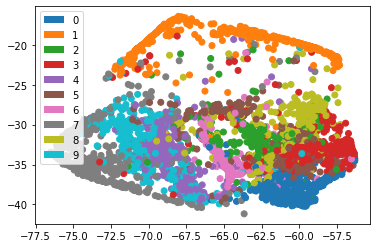

In [80]:
colors = [plt.cm.tab10.colors[i] for i in mnist_labels[:pred_num]]
scat = plt.scatter(pred[:,0],pred[:,1],c=colors)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
plt.legend(recs,list(range(10)),loc=2)

In [64]:
pred2 = foo(mnist_imgdata[17000:18000].cuda()).cpu().detach()

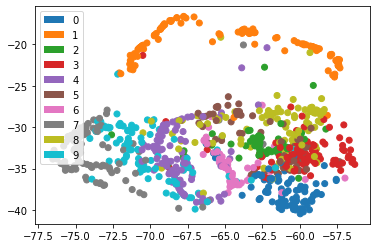

In [79]:
colors = [plt.cm.tab10.colors[i] for i in mnist_labels[17000:18000]]
scat = plt.scatter(pred2[:,0],pred2[:,1],c=colors)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
plt.legend(recs,list(range(10)),loc=2)